# Project Topic

### Predicting Bitcoin Price Using On-Chain Data: A Multiple Linear Regression Approach

This project aims to study the relationship between Bitcoin price and network on-chain data to develop a predictive model. Since Bitcoin price is a continuous variable, this problem falls under regression analysis, requiring the use of multiple linear models.

I specifically focused on blockchain activity rather than macroeconomic factors to evaluate whether on-chain metrics alone can accurately predict price movements, leading to a thorough data preprocessing phase.

Through this project, I hope to gain insights into leveraging temporal data for regression-based predictions.

Disclaimer: This notebook is for research purposes only and does not constitute investment recommendations.

In [1]:
#import io
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Data

I have been searching for a dataset that consolidates Bitcoin blockchain activity and price data on a daily basis. I found one on Kaggle that provides two datasets from distinct sources: Blockchain.com and LookIntoBitcoin.com.

Dataset link: Kaggle - [Bitcoin Network On-Chain Blockchain Data](https://www.kaggle.com/datasets/aleexharris/bitcoin-network-on-chain-blockchain-data).

In this section, I will directly load these datasets and examine their structure before merging them into a unified dataset.

In [2]:
# Download latest version
kaggle_path = kagglehub.dataset_download("aleexharris/bitcoin-network-on-chain-blockchain-data")

In [3]:
df1 = pd.read_csv(kaggle_path+'/blockchain_dot_com_daily_data.csv')
df1.tail()

,datetime,mempool_size,transaction_rate,market_cap_usd,average_block_size,market_price_usd,exchange_volume_usd,average_confirmation_time,hash_rate,difficulty,miners_revenue,total_transaction_fees
5351,2023-08-29,92829238.00,4.366667,5.085026e+11,1.658419,26108.31,7.316306e+07,58.918310,4.368632e+08,5.562144e+13,2.689015e+07,21.151151
5352,2023-08-30,24732393.50,3.658333,5.339097e+11,1.623768,27731.23,2.914660e+08,29.863134,3.483846e+08,5.562144e+13,2.209441e+07,19.220988
5353,2023-08-31,51403039.75,3.766667,5.300776e+11,1.648731,27301.12,1.246572e+08,40.942787,3.981538e+08,5.562144e+13,2.496186e+07,26.540640
5354,2023-09-01,73927621.00,3.808333,5.064906e+11,1.688033,25932.99,1.474262e+08,58.477930,4.175085e+08,5.562144e+13,2.512079e+07,26.151918
5355,2023-09-02,83152531.00,3.058333,5.029652e+11,1.706113,25802.10,1.320247e+08,73.001692,4.202735e+08,5.562144e+13,2.514410e+07,23.261978


|Variable |	Description| Include|
|:---------|:-------------|:---------|
|datetime 	| Daily basis| &check;|
|mempool_size |	The aggregate size of transactions waiting to be confirmed.| &check;|
|transaction_rate |	The number of Bitcoin transactions added to the mempool per second.| &check;|
|market_cap_usd |	The current valuation of the Bitcoin network, calculated by the current price of Bitcoin multiplied by the total supply.| &cross;|
|average_block_size |	The average block size in MB.| &check;|
|market_price_usd |	Average USD market price across major Bitcoin exchanges.| &check;|
|exchange_volume_usd| The total USD value of trading volume on major Bitcoin exchanges.| &cross;|
|average_confirmation_time | The average time taken for a transaction to be combined in a Bitcoin block with other transactions and added to the blockchain.| &check;|
|hash_rate | The estimated number of tera hashes per second (trillions of hashes per second) the Bitcoin network is performing.| &check;|
|difficulty |	 A relative measure of how difficult it is to find a new block. The difficulty is adjusted periodically as a function of how much hashing power has been deployed by the network of miners.| &check;|
|miners_revenue |	Total value of coinbase block rewards and transaction fees paid to miners in USD.| &check;|
|total_transaction_fees |	The total value of all transaction fees paid to miners (not including the coinbase value of block rewards) in BTC.| &check;|


In [4]:
df2 = pd.read_csv(kaggle_path+'/look_into_bitcoin_daily_data.csv')
df2.tail()

,datetime,market_price_usd,total_supply,market_cap_usd,realised_cap_usd,nupl,coin_days_destroyed,active_addresses,fear_greed_value,fear_greed_category,lightning_nodes,lightning_capacity_usd
4759,2023-08-28,26089.0,19470121,5.079560e+11,3.953435e+11,0.221697,6.143845e+06,878193.0,39.0,Fear,17728.0,1.204406e+08
4760,2023-08-29,27720.0,19471108,5.397391e+11,3.953451e+11,0.267526,1.399664e+07,1051269.0,39.0,Fear,17728.0,1.273968e+08
4761,2023-08-30,27306.0,19471896,5.316996e+11,3.953394e+11,0.256461,5.532277e+06,880620.0,49.0,Neutral,17728.0,1.270667e+08
4762,2023-08-31,25937.0,19472796,5.050659e+11,3.951526e+11,0.217622,6.442777e+06,996890.0,52.0,Neutral,17693.0,1.215603e+08
4763,2023-09-01,25789.0,19473739,5.022083e+11,3.950670e+11,0.213340,6.333374e+06,1030029.0,40.0,Fear,17693.0,1.209844e+08


|Variable |	Description| Include|
|:---------|:-------------|:---------|
|datetime 	| Daily basis| &check;|
|market_price_usd |	Price of Bitcoin in USD according to lookintobitcoin.com| &check;|
|total_supply |	The total number of Bitcoins in circulation on the given date.| &cross;|
|market_cap_usd |	The current valuation of the Bitcoin network, calculated by the current price of Bitcoin multiplied by the total supply.| &cross;|
|realised_cap_usd |	The sum of the price of each Bitcoin when it was last moved.| &cross;|
|nupl |	Net Unrealized Profit/Loss (NUPL) estimates the total paper profit/loss of Bitcoin investors, calculated with the formula: 1 - realised_cap / market_cap| &cross;|
|coin_days_destroyed| Coin Days Destroyed (CDD) takes the number of coins that have moved on-chain at a particular time and multiples that value by the number of days since those coins were last moved.| &cross;|
|active_addresses |	The number of addresses on the Bitcoin blockchain that either sent or received transactions.| &check;|
|fear_greed_value |	Proprietary multi-factor Bitcoin market sentiment index produced by lookintobitcoin.com: a value of 0 indicates extreme levels of investor fear and 100 indicates extreme levels of investor greed.| &cross;|
|fear_greed_category | Maps the numerical value of Fear and Greed to a 5-point Likert scale: Extreme Fear, Fear, Neutral, Greed, Extreme Greed.| &cross;|
|lightning_nodes | The total number of Bitcoin Lightning nodes, measured weekly and forward filled for the rest of the week.| &check;|
|lightning_capacity_usd |	The cumulative capacity held by all nodes on the Lightning Network in USD.| &cross;|


These datasets contain market price data, additional market-related metrics, and on-chain data such as hash rate and the number of active addresses, spanning Bitcoin’s early network phase. Given that Bitcoin is designed to produce a block approximately every 10 minutes, the data is aggregated daily.


Below is the size, including the number of rows and columns, for each dataset.

In [5]:
print(df1.shape)
print(df2.shape)

(5356, 12)
(4764, 12)


# Data Cleaning

### Merge

Since some columns are not directly related to on-chain activity or are derived solely from market price data, I will exclude those that are market-price-related.

In [6]:
# Exclude from the first
df1_confined = df1.drop(['market_cap_usd', 'market_price_usd', 'exchange_volume_usd'], axis=1, inplace=False)
# Subset from the second
df2_confined = df2[['datetime', 'market_price_usd', 'active_addresses', 'lightning_nodes']]

print(df1_confined.shape)
print(df2_confined.shape)

(5356, 9)
(4764, 4)


Additionally, the two datasets have different timeframes and row counts. The second dataset omits data from Bitcoin’s early stages, whereas the first dataset fills in missing price values with zeros. To ensure consistency, I will remove entries that lack price information and merge the datasets using an inner join, ensuring that both contain matching records.

In [7]:
df_merged = pd.merge(left=df2_confined, right=df1_confined, how="inner", on="datetime")
df_merged.head()

,datetime,market_price_usd,active_addresses,lightning_nodes,mempool_size,transaction_rate,average_block_size,average_confirmation_time,hash_rate,difficulty,miners_revenue,total_transaction_fees
0,2010-08-17,0.07,494.0,0.0,0.0,0.0,0.000676,0.0,0.003333,511.773534,0.0000,0.00
1,2010-08-18,0.07,726.0,0.0,0.0,0.0,0.002006,0.0,0.003384,511.773534,472.6092,1.56
2,2010-08-19,0.07,470.0,0.0,0.0,0.0,0.000624,0.0,0.003562,511.773534,479.5000,0.00
3,2010-08-20,0.07,656.0,0.0,0.0,0.0,0.000596,0.0,0.004249,511.773534,682.5000,0.00
4,2010-08-21,0.07,528.0,0.0,0.0,0.0,0.000539,0.0,0.004681,511.773534,605.5000,0.00


In [8]:
print(df_merged.shape)

(4764, 12)


### Missing Values

In [9]:
print(df_merged.info())
print("\nMissing Values:\n", df_merged.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4764 entries, 0 to 4763
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   datetime                   4764 non-null   object 
 1   market_price_usd           4764 non-null   float64
 2   active_addresses           4762 non-null   float64
 3   lightning_nodes            4764 non-null   float64
 4   mempool_size               4764 non-null   float64
 5   transaction_rate           4764 non-null   float64
 6   average_block_size         4764 non-null   float64
 7   average_confirmation_time  4764 non-null   float64
 8   hash_rate                  4764 non-null   float64
 9   difficulty                 4764 non-null   float64
 10  miners_revenue             4764 non-null   float64
 11  total_transaction_fees     4764 non-null   float64
dtypes: float64(11), object(1)
memory usage: 446.8+ KB
None

Missing Values:
 datetime                     0


In [10]:
df_merged.loc[df_merged.isnull().any(axis=1)]

,datetime,market_price_usd,active_addresses,lightning_nodes,mempool_size,transaction_rate,average_block_size,average_confirmation_time,hash_rate,difficulty,miners_revenue,total_transaction_fees
4231,2022-03-18,41818.0,NaN,20707.0,1471575.75,3.216667,1.280325,13.769673,1.951495e+08,2.745271e+13,3.695927e+07,10.594884
4708,2023-07-08,30298.0,NaN,18054.0,63533959.75,3.325000,1.751515,1212.410677,4.481393e+08,5.064621e+13,3.411402e+07,14.740246


I did not find any missing values except in the **active_addresses** column. However, it is unlikely that no activity occurred on specific days, as miners would have earned fees paid by multiple addresses.

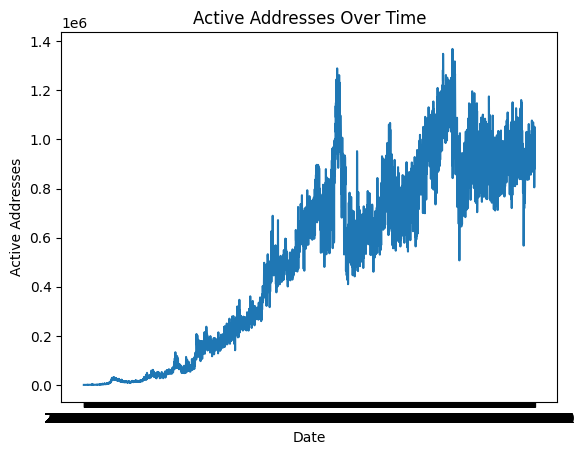

In [11]:
plt.plot(df_merged['datetime'], df_merged['active_addresses'])
plt.xlabel("Date")
plt.ylabel("Active Addresses")
plt.title("Active Addresses Over Time")
plt.show()

In [12]:
# Before index 4231
print(df_merged[['datetime','active_addresses']].iloc[[4229,4230,4231,4232,4233]], '\n')

# Interpolation
df_merged['active_addresses'] = df_merged['active_addresses'].interpolate(method='linear')

# After index 4231
print(df_merged[['datetime','active_addresses']].iloc[[4229,4230,4231,4232,4233]])

        datetime  active_addresses
4229  2022-03-16         1018750.0
4230  2022-03-17         1037510.0
4231  2022-03-18               NaN
4232  2022-03-19          887796.0
4233  2022-03-20          790049.0 

        datetime  active_addresses
4229  2022-03-16         1018750.0
4230  2022-03-17         1037510.0
4231  2022-03-18          962653.0
4232  2022-03-19          887796.0
4233  2022-03-20          790049.0


Because the **active_addresses** column has a wide range of values, imputing the mean may not be the best approach. Instead, I used interpolation to estimate missing values based on trends in the data.

### Nonsensical Zero Values

Given that all columns are of type float64, I needed to identify zero values that might be nonsensical.

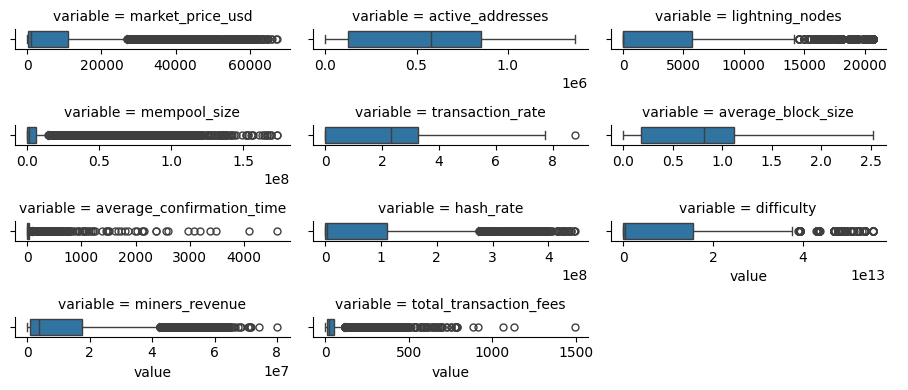

In [13]:
numeric_columns = df_merged.select_dtypes(include=[np.number]).columns
df_melted = df_merged.melt(value_vars=numeric_columns)

sns.catplot(x='value', col='variable', col_wrap=3, data=df_melted, kind='box', sharex=False, sharey=False, height=1, aspect=3)
plt.show()

In [14]:
# No entry
df_merged.loc[df_merged['active_addresses'] <= 100].head()

,datetime,market_price_usd,active_addresses,lightning_nodes,mempool_size,transaction_rate,average_block_size,average_confirmation_time,hash_rate,difficulty,miners_revenue,total_transaction_fees


In [15]:
# Not zero
df_merged.loc[df_merged['average_block_size'] <= 0.1].sort_values(by='average_block_size')['average_block_size'].head(2)

,average_block_size
18,0.000409
12,0.000414


In [16]:
# Not zero
df_merged.loc[df_merged['hash_rate'] <= 0.1].sort_values(by='hash_rate')['hash_rate'].head(2)

,hash_rate
0,0.003333
1,0.003384


In [17]:
# Implausible
df_merged.loc[df_merged['miners_revenue'] <= 0.1]

,datetime,market_price_usd,active_addresses,lightning_nodes,mempool_size,transaction_rate,average_block_size,average_confirmation_time,hash_rate,difficulty,miners_revenue,total_transaction_fees
0,2010-08-17,0.07,494.0,0.0,0.0,0.0,0.000676,0.0,0.003333,511.773534,0.0,0.0


In [18]:
# Unrealistic
df_merged.loc[df_merged['total_transaction_fees'] == 0].sort_values(by='datetime')

,datetime,market_price_usd,active_addresses,lightning_nodes,mempool_size,transaction_rate,average_block_size,average_confirmation_time,hash_rate,difficulty,miners_revenue,total_transaction_fees
0,2010-08-17,0.07,494.0,0.0,0.0,0.0,0.000676,0.0,0.003333,511.773534,0.0,0.0
2,2010-08-19,0.07,470.0,0.0,0.0,0.0,0.000624,0.0,0.003562,511.773534,479.5,0.0
3,2010-08-20,0.07,656.0,0.0,0.0,0.0,0.000596,0.0,0.004249,511.773534,682.5,0.0
4,2010-08-21,0.07,528.0,0.0,0.0,0.0,0.000539,0.0,0.004681,511.773534,605.5,0.0
5,2010-08-22,0.06,586.0,0.0,0.0,0.0,0.000473,0.0,0.005063,511.773534,742.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
91,2010-11-16,0.25,3365.0,0.0,0.0,0.0,0.010954,0.0,0.040816,4536.353723,2870.0,0.0
92,2010-11-17,0.26,675.0,0.0,0.0,0.0,0.000505,0.0,0.056376,4536.353723,3654.0,0.0
93,2010-11-18,0.27,632.0,0.0,0.0,0.0,0.001375,0.0,0.059307,4536.353723,3738.0,0.0
100,2010-11-25,0.28,912.0,0.0,0.0,0.0,0.009518,0.0,0.051886,6866.898649,2562.0,0.0


By analyzing the boxplots, I identified a few suspicious columns containing zero values. Among them, the **miners_revenue** column had a single entry showing zero miner revenue, which is implausible. Additionally, the **total_transaction_fees** column contained some entries with unrealistic zero values despite recorded address activity.

As these rows belonged to the initial stage of the dataset and their size was minimal compared to the overall dataset, I removed them entirely along with the normal data in-between for simplicity.

In [19]:
# Find the last index
last_index = df_merged.loc[df_merged['total_transaction_fees'] == 0].sort_values(by='datetime', ascending=False).index[0]

df_final = df_merged.iloc[last_index+1:]

print(len(df_merged), len(df_final), len(df_merged)-len(df_final), '\n')
print(df_final.head(2))

4764 4660 104 

       datetime  market_price_usd  active_addresses  lightning_nodes  \
104  2010-11-29              0.25             900.0              0.0   
105  2010-11-30              0.21             797.0              0.0   

     mempool_size  transaction_rate  average_block_size  \
104           0.0               0.0            0.000692   
105           0.0               0.0            0.000646   

     average_confirmation_time  hash_rate   difficulty  miners_revenue  \
104                        0.0   0.072367  6866.898649       3066.0084   
105                        0.0   0.084330  8078.195258       2968.0028   

     total_transaction_fees  
104                    0.03  
105                    0.01  


### Summary of Preprocessing
|Issue Identified |	Action Taken | Rationale |
|:---------|:-------------|:---------|
| Unrelated columns | Drop columns | Alignment for irrelevance |
| Missing values in bitcoin price | Drop rows	| Data Integrity |
| Missing values in number of active addresses 	| Imputation through interpolation | Continuity |
| Invalid Zero Values |	Drop row | Data Integrity |


# Exploratory Data Analysis

### Analyze Correlations

In [20]:
correlation_matrix = df_final.corr(numeric_only=True)
correlation_matrix

,market_price_usd,active_addresses,lightning_nodes,mempool_size,transaction_rate,average_block_size,average_confirmation_time,hash_rate,difficulty,miners_revenue,total_transaction_fees
market_price_usd,1.000000,0.701940,0.846409,0.391679,0.579793,0.647028,0.249501,0.728602,0.732138,0.954433,0.019414
active_addresses,0.701940,1.000000,0.685866,0.509365,0.912528,0.945279,0.289720,0.691673,0.690375,0.764477,0.340967
lightning_nodes,0.846409,0.685866,1.000000,0.297389,0.609808,0.713798,0.149212,0.930188,0.934869,0.762456,-0.129542
mempool_size,0.391679,0.509365,0.297389,1.000000,0.466618,0.530352,0.416951,0.446743,0.455195,0.453922,0.559216
transaction_rate,0.579793,0.912528,0.609808,0.466618,1.000000,0.888601,0.217054,0.646757,0.645906,0.654613,0.341390
average_block_size,0.647028,0.945279,0.713798,0.530352,0.888601,1.000000,0.279429,0.758725,0.767113,0.674131,0.253081
average_confirmation_time,0.249501,0.289720,0.149212,0.416951,0.217054,0.279429,1.000000,0.213084,0.204037,0.301802,0.246687
hash_rate,0.728602,0.691673,0.930188,0.446743,0.646757,0.758725,0.213084,1.000000,0.992314,0.679124,-0.084923
difficulty,0.732138,0.690375,0.934869,0.455195,0.645906,0.767113,0.204037,0.992314,1.000000,0.668892,-0.082762
miners_revenue,0.954433,0.764477,0.762456,0.453922,0.654613,0.674131,0.301802,0.679124,0.668892,1.000000,0.171103


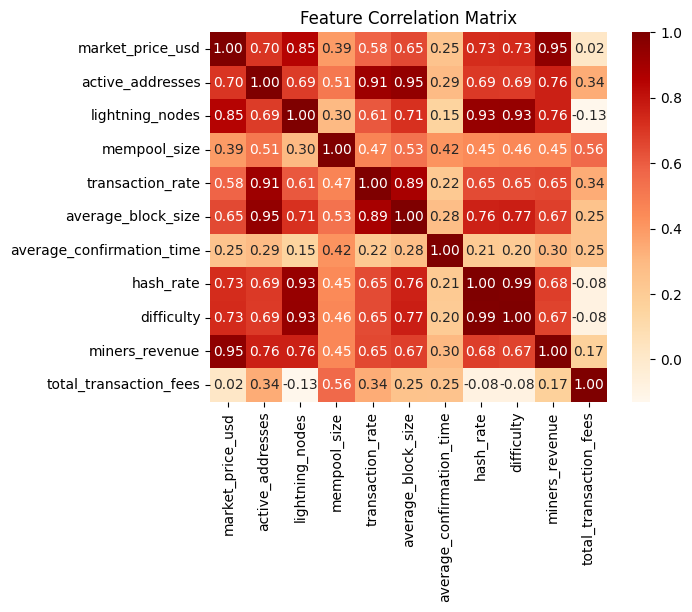

In [21]:
sns.heatmap(correlation_matrix, annot=True, cmap='OrRd', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


In [22]:
print(correlation_matrix.market_price_usd.sort_values(ascending=False))

market_price_usd             1.000000
miners_revenue               0.954433
lightning_nodes              0.846409
difficulty                   0.732138
hash_rate                    0.728602
active_addresses             0.701940
average_block_size           0.647028
transaction_rate             0.579793
mempool_size                 0.391679
average_confirmation_time    0.249501
total_transaction_fees       0.019414
Name: market_price_usd, dtype: float64


From the heatmap of Pearson correlation coefficients between features and Bitcoin price, I identified the following positive correlations:

1. Strong Positive Correlations
  - **miners_revenue, difficulty, hash_rate** - Higher values of miner-related metrics, such as increased computing power and revenue, may indicate upward price movements.
  - **lightning_nodes** - A greater number of nodes participating in the Lightning Network suggests increased demand for Bitcoin.
  - **active_addresses** - More network activity is often associated with higher Bitcoin prices.

2. Moderate Positive Correlations
  - Some network size metrics (e.g., block size, mempool size, transaction rate) exhibited a moderate impact on price fluctuations.

3. Weak or No Correlations
  - **average_confirmation_time** – Theoretically, this value should be relatively stable. While it may vary, it does not directly influence price movements.
  - Unexpectedly, transaction fees paid to miners had little to no effect on Bitcoin price.

Additional Observations

The difficulty and hash rate columns have a strong correlation, as mining difficulty sets the threshold for finding a valid hash.
The number of Lightning Network nodes and mining activity metrics also exhibited a strong correlation, though the exact relationship is unclear. While I cannot definitively conclude that intense competition among miners drives this association, there is a notable link.
Increased address activity appears to contribute to mempool congestion, understandably leading to larger block sizes due to rapid transaction submissions.

Remedy

To improve the fitting the model, I need to address multicollinearity issues, as strongly correlated features may introduce redundancy and distort the predictive model.


### Pairplot

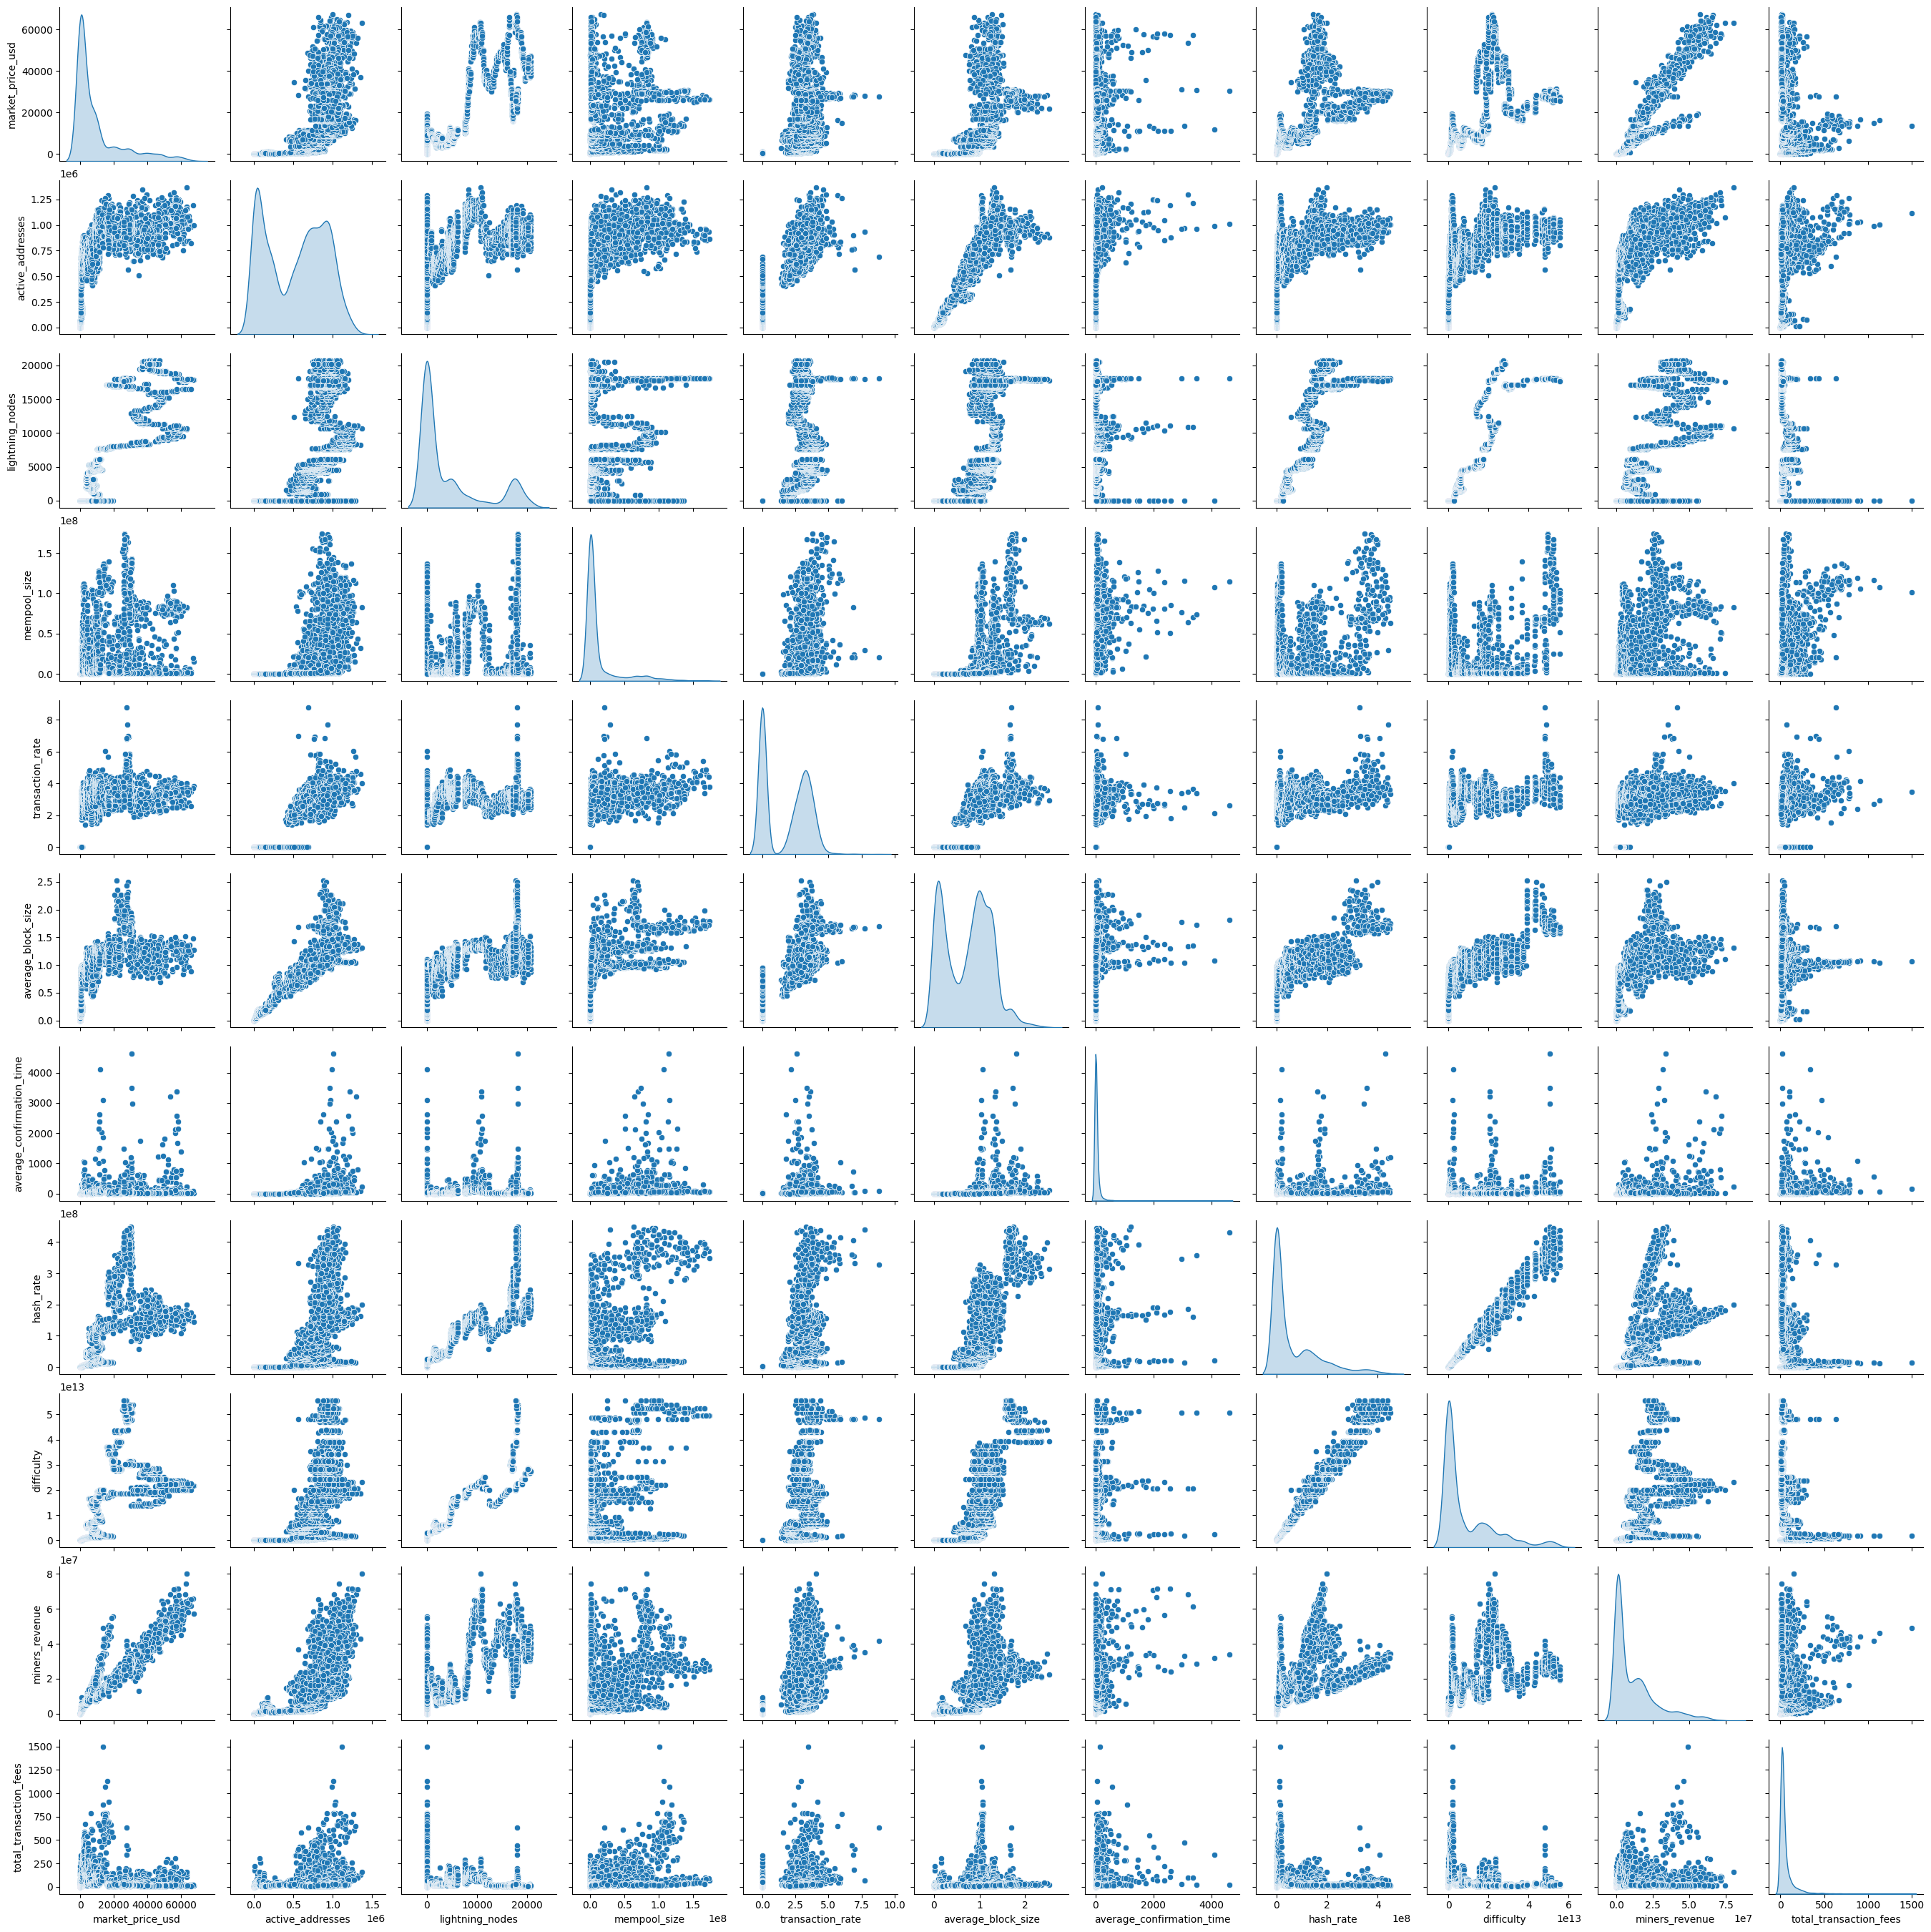

In [23]:
sns.pairplot(df_final, diag_kind = 'kde')

From the histograms in the diagonal of pairplot which represent the distribution of each individual variable, I inspected the following observations:

- For Bitcoin price, mempool size, average confirmation time and transaction fees show right skewness, this indicates that most values are clustered at lower levels, but a few extreme values pull the mean higher.

- For active addresses, transaction rate, or block size, has two peaks which suggests that there could be a seasonal or event-driven activity or distict operational phases in the network history.

Implication

Right-skewed data may influence model performance which require transformation or removal of outliers. The bimodal distributions may need further segmentation analysis to help understand its changes.

# Models

### Drop Column

In [24]:
df_final = df_final.drop(['datetime', 'difficulty'], axis=1, inplace=False)

In this part, I removed the **difficulty** column to address the collinearity issue, as it was strongly correlated with other variables. I also deleted the **datetime** column, as it was no longer useful for the analysis.

### Normalize

In [25]:
df_normalized = (df_final - df_final.mean()) / df_final.std()
df_normalized.head()

,market_price_usd,active_addresses,lightning_nodes,mempool_size,transaction_rate,average_block_size,average_confirmation_time,hash_rate,miners_revenue,total_transaction_fees
104,-0.660668,-1.414672,-0.661831,-0.45986,-1.088192,-1.437359,-0.258594,-0.669981,-0.795604,-0.591982
105,-0.660671,-1.414948,-0.661831,-0.45986,-1.088192,-1.437449,-0.258594,-0.669981,-0.795611,-0.592186
106,-0.660671,-1.414113,-0.661831,-0.45986,-1.088192,-1.437012,-0.258594,-0.669981,-0.795642,-0.591879
107,-0.660669,-1.414908,-0.661831,-0.45986,-1.088192,-1.437350,-0.258594,-0.669981,-0.795665,-0.591674
108,-0.660668,-1.414723,-0.661831,-0.45986,-1.088192,-1.437371,-0.258594,-0.669981,-0.795649,-0.592186


L1 (Lasso) and L2 (Ridge) regularization, normalization is necessary because the regularization penalizes large coefficients, and without normalization, features with larger scales dominate the penalty, leading to biased results.

### Split the Dataset

In [26]:
X = df_normalized.drop(['market_price_usd'], axis=1, inplace=False)
y = df_normalized['market_price_usd']

# Split the data to train and test datasets such that the test dataset is 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(len(df_normalized), len(X_train), len(X_test), len(y_train), len(y_test))

4660 3728 932 3728 932


### OLS

In [27]:
ols_model = sm.OLS(y_train, X_train).fit()
print(ols_model.summary())

prediction = ols_model.predict(X_test)
print('\n', mean_squared_error(y_test, prediction))

                                 OLS Regression Results                                
Dep. Variable:       market_price_usd   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                          1.247e+04
Date:                Tue, 04 Mar 2025   Prob (F-statistic):                        0.00
Time:                        09:48:35   Log-Likelihood:                          1093.6
No. Observations:                3728   AIC:                                     -2169.
Df Residuals:                    3719   BIC:                                     -2113.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

### Search Alpha

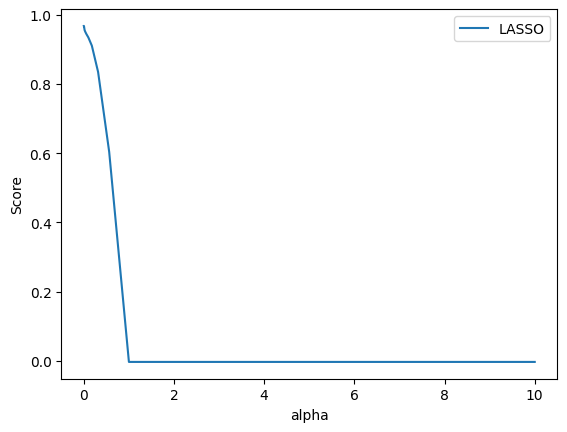

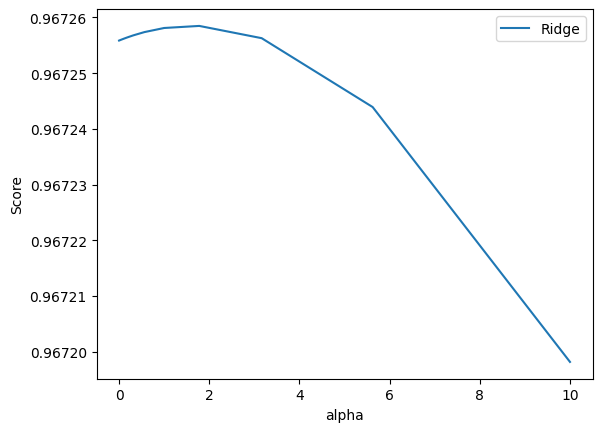

Best hyperparamter 0.00017782794100389227 1.7782794100389228


In [28]:
param_grid = {'alpha': np.logspace(-5, 1, 25)}

# LASSO
lasso = Lasso()
grid_search_1 = GridSearchCV(lasso, param_grid=param_grid, cv=10).fit(X_train, y_train)
search_res_1 = pd.DataFrame(grid_search_1.cv_results_)

# Ridge
ridge = Ridge()
grid_search_2 = GridSearchCV(ridge, param_grid=param_grid, cv=10).fit(X_train, y_train)
search_res_2 = pd.DataFrame(grid_search_2.cv_results_)

# Plot
plt.plot(search_res_1.param_alpha, search_res_1.mean_test_score, label = "LASSO")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.legend()
plt.show()

plt.plot(search_res_2.param_alpha, search_res_2.mean_test_score, label = "Ridge")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.legend()
plt.show()

# Get the best hyperparameters
best_alpha_1 = grid_search_1.best_params_['alpha']
best_alpha_2 = grid_search_2.best_params_['alpha']
print('Best hyperparamter', best_alpha_1, best_alpha_2)


### LASSO

In [29]:
lasso_model = Lasso(alpha=best_alpha_1).fit(X_train, y_train)
print(lasso_model.score(X_train, y_train))
print(lasso_model.score(X_test, y_test))

prediction = lasso_model.predict(X_test)
print(mean_squared_error(y_test, prediction))

0.9679300482121661
0.9651504090073687
0.03258930522622703


### Ridge

In [30]:
ridge_model = Ridge(alpha=best_alpha_2).fit(X_train, y_train)

print(ridge_model.score(X_train, y_train))
print(ridge_model.score(X_test, y_test))

prediction = ridge_model.predict(X_test)
print(mean_squared_error(y_test, prediction))

0.9679318363857321
0.9651618237039645
0.0325786308676239


# Results and Analysis

Among the three models—full OLS, Lasso, and Ridge—their performance is quite similar. Based on the evaluation metrics of $R^2$ score and mean squared error (MSE), it is difficult to definitively determine which model is superior.

                    features  importances
6                  hash_rate    -0.369191
8     total_transaction_fees    -0.104756
0           active_addresses    -0.073503
3           transaction_rate    -0.067763
5  average_confirmation_time    -0.002310
4         average_block_size     0.086640
2               mempool_size     0.115283
1            lightning_nodes     0.591923
7             miners_revenue     0.761732


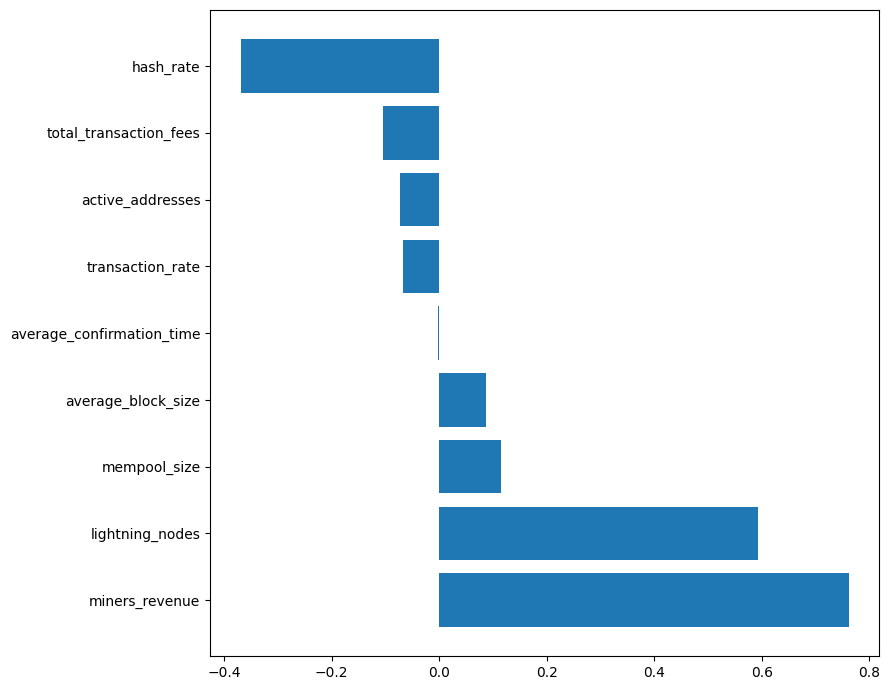

In [31]:
# Importance of features
print(pd.DataFrame(list(zip(X_train.columns, ridge_model.coef_)), columns=['features', 'importances']).sort_values('importances'))

# Plot the importance
coef_df = pd.DataFrame(list(zip(X_train.columns, ridge_model.coef_)))
coef_df.columns=['feature', 'coef']
coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(9, 7))
ax.barh(np.arange(len(coef_df)), coef_df['coef'])
idx = np.arange(len(coef_df))
ax.set_yticks(idx)
ax.set_yticklabels(coef_df['feature'])
fig.tight_layout()
plt.show()

By analyzing the importance of features, I observed both positive and negative coefficients in the Ridge linear regression model, which indicate their influence on Bitcoin price.

  - Positive coefficients: The features lightning nodes and miners' revenue have a significant positive impact, meaning that as these features increase, Bitcoin price tends to rise.
  - Negative coefficient: The hash rate has a negative coefficient, suggesting that an increase in hash rate is associated with a decrease in Bitcoin price, making it the most impactful feature in this regard.

Additionally, I identified unimportant features. The **average_confirmation_time** feature has a small importance level, which aligns with its statistical insignificance observed in the OLS results.

# Discussion and Conclusion

Learning and Takeaways
- Many on-chain metrics are highly correlated with each other which caused instability in the model because when two features are nearly redundant, the regression struggles to assign proper weights, often leading to inconsistent or misleading coefficients.
- Some features had strong positive correlations with Bitcoin price (e.g., mining revenue, lightning nodes), while others had negative relationships (e.g., hash rate).

Things That Didn’t Work
- Lasso Regression: Despite performing a hyperparameter search, the optimal alpha value was extremely small, which was unexpected given the presence of highly correlated predictors. Essentially, Lasso barely applied any regularization, causing the model to behave similarly to ordinary least squares (OLS).
- Unexpected Coefficient Signs: Some feature coefficients had signs that contradicted intuition, likely due to multicollinearity distorting their effects.

Suggested Improvements
- Addressing Multicollinearity: The instability in the model is clearly caused by multicollinearity. This issue reduces confidence in the fitted model and highlights areas for future refinement.
- Dimensionality Reduction: Exploring methods such as Principal Component Analysis (PCA) or Variance Inflation Factor (VIF) can help identify and remove redundant variables, potentially improving model stability and interpretability.
- I need to revisit and thoroughly study the concept of feature selection, along with methods to address multicollinearity, to better understand and apply effective techniques for improving my model’s stability and accuracy.

# Write-up

This study aimed to predict Bitcoin price based on key on-chain activity metrics using multiple linear regression with L1/L2 regularization. The goal was to understand which blockchain network features influence price fluctuations.